Práctica Final NLP José Carlos Amo Pérez
## 4. Reporte de métricas y conclusiones

Citation:

<small>Ups and downs: Modeling the visual evolution of fashion trends with one-class collaborative filtering
R. He, J. McAuley
WWW, 2016
https://cseweb.ucsd.edu/~jmcauley/pdfs/sigir15.pdf</small>

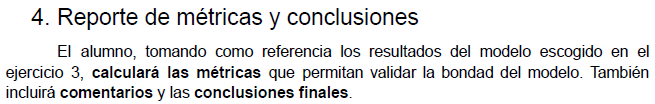

In [2]:
# Carga e importación de librerias:
!python -m spacy download en_core_web_sm
!pip install stop_words
!pip install num2words
!pip install contractions

import nltk
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize import word_tokenize
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize.treebank import TreebankWordDetokenizer
import spacy
import unicodedata
from num2words import num2words
from stop_words import get_stop_words
import string
import re
import pandas as pd
import numpy as np
import gzip
import en_core_web_sm
from collections import Counter
import matplotlib.pyplot as plt
from nltk import ngrams
from nltk.probability import FreqDist
from nltk import FreqDist
from nltk.corpus import stopwords
from wordcloud import WordCloud
import io
import decimal
from decimal import Decimal, InvalidOperation
import contractions
from nltk.tokenize.treebank import TreebankWordDetokenizer
from gensim.models import Word2Vec
from gensim.models.word2vec import LineSentence
from collections import defaultdict
import logging
logging.basicConfig(format="%(levelname)s - %(asctime)s: %(message)s", datefmt= '%H:%M:%S', level=logging.INFO)
from gensim.models.phrases import Phrases, Phraser
import multiprocessing
import random
from nltk.corpus import wordnet as wn
from sklearn.model_selection import GridSearchCV



/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
2023-03-12 19:21:19.851496: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-12 19:21:21.383600: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2023-03-12 19:21:21.383710: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open share

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
/usr/local/lib/python3.9/dist-packages/torch/cuda/__init__.py:497: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [16]:
# Cargo cada conjunto de datos de resultados de cda modelo entrenado en la etapa de entrenamiento y testeo de un modelo
# de análisis de sentimiento
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

dfMetricas_LR = pd.read_csv('/content/gdrive/My Drive/NLP/Metricas_modelo1_lr.csv')
dfCR_LR = pd.read_csv('/content/gdrive/My Drive/NLP/CR_Modelo1_lr.csv')

dfMetricas_KNN = pd.read_csv('/content/gdrive/My Drive/NLP/Metricas_modelo2_KNN.csv')
dfCR_KNN = pd.read_csv('/content/gdrive/My Drive/NLP/CR_Modelo2_KNN.csv')

dfMetricas_NAIVEB = pd.read_csv('/content/gdrive/My Drive/NLP/Metricas_modelo3_NaiveB.csv')
dfCR_NAIVEB = pd.read_csv('/content/gdrive/My Drive/NLP/CR_Modelo3_NaiveB.csv')

Mounted at /content/gdrive


In [17]:
dfMetricas_LR.head(10)

,Indicador,Valor
0,TN,224.000000
1,FP,78.000000
2,FN,100.000000
3,TP,218.000000
4,Accuracy,0.712903
5,Precision,0.736486
6,Recall,0.685535
7,Especificity,0.741722


In [18]:
dfMetricas_KNN.head(10)

,Indicador,Valor
0,TN,178.000000
1,FP,124.000000
2,FN,120.000000
3,TP,198.000000
4,Accuracy,0.606452
5,Precision,0.614907
6,Recall,0.622642
7,Especificity,0.589404


In [19]:
dfMetricas_NAIVEB.head(10)

,Indicador,Valor
0,TN,221.000000
1,FP,81.000000
2,FN,100.000000
3,TP,218.000000
4,Accuracy,0.708065
5,Precision,0.729097
6,Recall,0.685535
7,Especificity,0.731788


In [7]:
valor = dfMetricas_LR.iloc[0, 1]

print(valor)

224.0


Para elegir el mejor modelo (en este caso el menos malo) voy a calcular los valroes de:
- “Accuracy” (Exactitud): proporcion de predicciones correctas Accuracy = (VP+VN)/(VP+FP+FN+VN)
- “Precision”: proporcion de "1" detectados Precision = VP/(VP+FP)
- “Recall” o “Sensitivity”: proporción de casos "1" correctamente detectados Recall = VP/(VP+FN)

Estos valores se interpretan de la siguiente manera:

- **Alta precisión y alto recall**: el modelo de Machine Learning escogido maneja perfectamente esa clase.

- **Alta precisión y bajo recall**: el modelo de Machine Learning escogido no detecta la clase muy bien, pero cuando lo hace es altamente confiable.

- **Baja precisión y alto recall**: El modelo de Machine Learning escogido detecta bien la clase,  pero también incluye muestras de la otra clase.

- **Baja precisión y bajo recall**: El modelo de Machine Learning escogido no logra clasificar la clase correctamente.

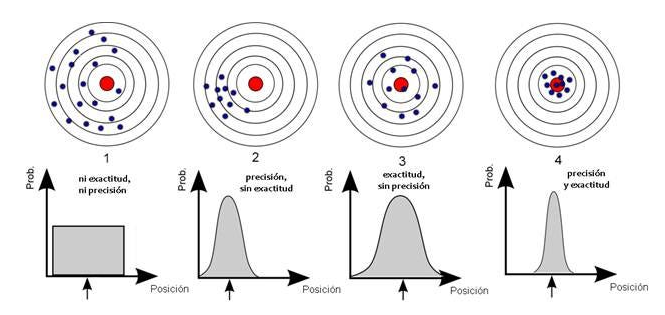

In [24]:
AccLR = dfMetricas_LR.iloc[4,1]
PrecisionLR = dfMetricas_LR.iloc[5,1]
RecallLR = dfMetricas_LR.iloc[6,1]
print(f'En el modelo de Regresión Logarítmica, Accuracy = {AccLR}, Precisión = {PrecisionLR} y Recall = {RecallLR}')

AccKNN = dfMetricas_KNN.iloc[4,1]
PrecisionKNN = dfMetricas_KNN.iloc[5,1]
RecallKNN = dfMetricas_KNN.iloc[6,1]
print(f'\nEn el modelo de KNN, Accuracy = {AccKNN}, Precisión = {PrecisionKNN} y Recall = {RecallKNN}')

AccNAIVEB = dfMetricas_NAIVEB.iloc[4,1]
PrecisionNAIVEB = dfMetricas_NAIVEB.iloc[5,1]
RecallNAIVEB = dfMetricas_NAIVEB.iloc[6,1]
print(f'\nEn el modelo de Naive Bayes, Accuracy = {AccNAIVEB}, Precisión = {PrecisionNAIVEB} y Recall = {RecallNAIVEB}')

En el modelo de Regresión Logarítmica, Accuracy = 0.7129032258064516, Precisión = 0.7364864864864865 y Recall = 0.6855345911949685

En el modelo de KNN, Accuracy = 0.6064516129032258, Precisión = 0.6149068322981367 y Recall = 0.6226415094339622

En el modelo de Naive Bayes, Accuracy = 0.7080645161290322, Precisión = 0.7290969899665551 y Recall = 0.6855345911949685


<font color="darkblue">**Conclusiones:**</font>

En términos de precisión, recall y exactitud, el modelo de regresión logística obtuvo los valores más altos en los tres indicadores. El modelo de Naive Bayes también tuvo un buen desempeño en los tres indicadores, mientras que el modelo de KNN tuvo el desempeño más bajo.

Antes de afirmar que el modelo de regresión logística parece ser el mejor, es importante tener en cuenta el contexto específico del problema, sobre el cual no tenemos muchos datos.

Si el cliente para el que estamos hacienco este modelo lo que necesita es saber cuántos de los comentarios identificados como positivos realmente son positivos entonces **la precision** sería el KPI determinante. Pero si lo que necesita saber es cuántos comentarios positivos se identificaron correctamente como positivos, entonces el KPI clave para decidir qué modelo es mejor es **el recall.** Desafortunadamente en el enunciado de esta práctica no se da esa información.

En todo caso, **si la metrica mas importante** es

- La **precisión** entonces el modelo de **regresión logística** parece el mejor.

- El **recall** entonces el modelo de **Naive Bayes** sería la opción a elegir.

<font color="darkblue">**Sugerencias para mejorar el modelado:**</font>

Aunque el corpues partía de más de 10k registros, los datos estaban muy desbalanceados. Tener que balancear ha disminuido mucho el numero de datos y con menos datos los modelos funcionan peor.

Por tanto la sugerencia es aumentar la diversidad y la cantidad de datos disponibles para entrenar los modelos con mejor capacidad de que estos  generalicen. Por supuesto esto requiere a la vez hacer un buen preprocesado de los datos ("garbage in, garbage out"). Como en nuestro problema aumentar los datos va a depender de aumentar ventas con malas calificaciones, nuestra capacidad de hacernos con más datos es  de hecho muy limitada.
